# Titanic
Acheiving 86% accuracy on a test data set using an xgboost classifier to predict whether a passenger survived the Titanic disaster

In [1]:
import pandas as pd
import numpy as np
from math import ceil

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
kaggle = pd.read_csv('test.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering
### Creating has_cabin

In [3]:
# does the first letter in cabin correlate to floor of ship?
grp = df.groupby(df['Cabin'].fillna('Z').apply(lambda x: x[0]))

# It looks like passengers without a cabin were significantly less likely to survive
grp.Survived.sum() / grp.Survived.count()

Cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Z    0.299854
Name: Survived, dtype: float64

In [4]:
# creating a column in our dataframe that holds whether or not Cabin is NaN
def create_has_cabin(cabin):
    if pd.notnull(cabin):
        return 1
    return 0

df['has_cabin'] = df['Cabin'].apply(create_has_cabin)
kaggle['has_cabin'] = kaggle['Cabin'].apply(create_has_cabin)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


### Binarizing Sex

In [5]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

In [6]:
map_sex = {'male':1, 'female':0}

df['is_male'] = df['Sex'].map(map_sex)
df.drop('Sex', axis=1, inplace=True)
kaggle['is_male'] = kaggle['Sex'].map(map_sex)
kaggle.drop('Sex', axis=1, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1


### Creating has_age

In [7]:
# creating a column in our dataframe that holds whether or not Cabin is NaN
def create_has_age(age):
    if pd.notnull(age):
        return 1
    return 0

df['has_age'] = df['Age'].apply(create_has_age)
kaggle['has_age'] = kaggle['Age'].apply(create_has_age)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male,has_age
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,1


In [8]:
grp = df.groupby(df['has_age'])

# passengers who have an age are more likely to have survived
grp.Survived.sum() / grp.Survived.count()

has_age
0    0.293785
1    0.406162
Name: Survived, dtype: float64

### Dealing with null Ages

In [9]:
def create_age_bin(age):
    bin_size = 5
    null_age_default = 42
    if np.isnan(age):
        return null_age_default
    return ceil(age/bin_size)*bin_size

df['age_bin'] = df['Age'].apply(create_age_bin)
kaggle['age_bin'] = kaggle['Age'].apply(create_age_bin)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male,has_age,age_bin
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1,25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,40
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,30
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1,35
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,1,35


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ab577b8>,
      dtype=object)

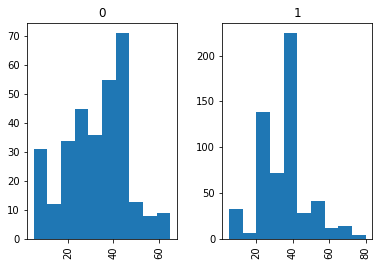

In [10]:
df.hist(column='age_bin', by='is_male')

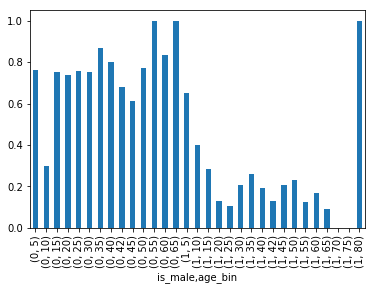

In [11]:
def get_survival_probability(group_df):
    bin_survivors = len(group_df[group_df['Survived'] == 1])
    bin_passengers = len(group_df)
    return bin_survivors/bin_passengers

series = df.groupby(['is_male', 'age_bin']).apply(get_survival_probability)
series.plot(kind='bar')

### Creating is_child

In [12]:
def create_is_child(age):
    if np.isnan(age):
        return 0
    if age <= 20:
        return 1
    return 0

df['is_child'] = df['Age'].apply(create_is_child)
kaggle['is_child'] = kaggle['Age'].apply(create_is_child)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male,has_age,age_bin,is_child
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1,25,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,40,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,30,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1,35,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,1,35,0


### Creating Dummies for Pclass

In [13]:
df = pd.concat([df, pd.get_dummies(df.Pclass, prefix='class')], axis=1);
kaggle = pd.concat([kaggle, pd.get_dummies(kaggle.Pclass, prefix='class')], axis=1);

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_cabin,is_male,has_age,age_bin,is_child,class_1,class_2,class_3
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1,25,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,40,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,30,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1,35,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,1,35,0,0,0,1


### Creating traveling_alone

In [14]:
# See if the person was traveing alone
df['family_size'] = df['Parch'] + df['SibSp'] + 1
kaggle['family_size'] = kaggle['Parch'] + kaggle['SibSp'] + 1

grp = df.groupby(df['family_size'])

# if you traveled alone, you had a 30% chance of survival
grp.Survived.sum() / grp.Survived.count()

family_size
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [15]:
grp.Survived.count()

family_size
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: Survived, dtype: int64

In [16]:
def create_family_buckets(family_size):
    if family_size == 1:
        return 1
    elif family_size <= 4:
        return 2
    return 3

df['family_bucket'] = df['family_size'].apply(create_family_buckets)
kaggle['family_bucket'] = kaggle['family_size'].apply(create_family_buckets)

df = pd.concat([df, pd.get_dummies(df.family_bucket, prefix='family_bucket')], axis=1);
kaggle = pd.concat([kaggle, pd.get_dummies(kaggle.family_bucket, prefix='family_bucket')], axis=1);

In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,age_bin,is_child,class_1,class_2,class_3,family_size,family_bucket,family_bucket_1,family_bucket_2,family_bucket_3
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,25,0,0,0,1,2,2,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,40,0,1,0,0,2,2,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,30,0,0,0,1,1,1,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,35,0,1,0,0,2,2,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,35,0,0,0,1,1,1,1,0,0


### Deal With Fare

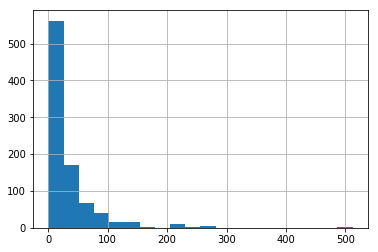

In [18]:
df['Fare'].hist(bins=20)

In [19]:
def cheap_ticket(fare):
    if fare < 80:
        return 1
    return 0

df['cheap_ticket'] = df['Fare'].apply(cheap_ticket)
kaggle['cheap_ticket'] = kaggle['Fare'].apply(cheap_ticket)

df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,is_child,class_1,class_2,class_3,family_size,family_bucket,family_bucket_1,family_bucket_2,family_bucket_3,cheap_ticket
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,0,0,0,1,2,2,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,0,1,0,0,2,2,0,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,1,1,1,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,0,1,0,0,2,2,0,1,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,0,0,0,1,1,1,1,0,0,1


In [20]:
# Does having an cheap ticket affect survival rate?
grp = df.groupby(df['cheap_ticket'])

# It looks like passengers who bought a cheap ticket were significantly less likely to survive
grp.Survived.sum() / grp.Survived.count()

cheap_ticket
0    0.776316
1    0.347239
Name: Survived, dtype: float64

### Splitting into Train/Test

In [21]:
# Making sure we have target values for each of our data points
df.Survived.unique()

array([0, 1])

The input to our model will be some of our numeric columns, the target will be 'Survived'

In [22]:
from sklearn.model_selection import train_test_split

model_input_columns = ['Fare',
                       'family_bucket_1',
                       'family_bucket_2',
                       'family_bucket_3',
                       'has_cabin',
                       'is_male',
                       'has_age',
                       'age_bin',
                       'is_child',
                       'class_1',
                       'class_2',
                       'class_3'
                      ]
X = df[model_input_columns]
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

## xgboost Model Creation

In [23]:
from xgboost import XGBClassifier

In [24]:
xgb = XGBClassifier(n_estimators=100,
                    max_depth=3,
                    learning_rate=.1,
                    subsample=.9,
                    colsample_bytree=1,
                    gamma=1
                   )
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [25]:
from sklearn.metrics import accuracy_score

# predict
y_pred = xgb.predict(X_train)

# evaluate predictions
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.53%


## xgboost Model Evaluation

In [26]:
# predict
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.10%


## Kaggle Competition Submission
Running our model on the dataset in test.csv and exporting the results to CSV

In [27]:
kaggle.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,is_child,class_1,class_2,class_3,family_size,family_bucket,family_bucket_1,family_bucket_2,family_bucket_3,cheap_ticket
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,Q,...,0,0,0,1,1,1,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,S,...,0,0,0,1,2,2,0,1,0,1
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,Q,...,0,0,1,0,1,1,1,0,0,1
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,S,...,0,0,0,1,1,1,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,S,...,0,0,0,1,3,2,0,1,0,1


In [28]:
kaggle_X = kaggle[model_input_columns]
kaggle['Survived'] = xgb.predict(kaggle_X)

In [29]:
submission_columns = ['PassengerId', 'Survived']
submission = kaggle[submission_columns]

In [30]:
submission.to_csv('kaggle-submission.csv', index=False)